#Machine Learning Explainability with SHAP
Estimated time needed: 45 minutes

In this Guided Project, we will walk through explainability techniques for various types of machine learning models. The purpose of Explainability in Machine Learning is to reveal the black box problem, in other words, to explain the reasoning that led to the model's output. Model insights are useful for the following reasons:

Debugging
Informing feature engineering
Directing future data collection
Informing human decision-making
Building trust
The algorythm that stands behind these Explainability techniques is called SHAP. SHAP stands for SHapley Additive exPlanations and it is a game theoretic approach that can explain the output of any machine learning model, without the knowledge of how the model works internally.


#Table of Contents
1. Objectives
2. Setup
   A. Installing Required Libraries
   B. Importing Required Libraries

3. What is explainabilty?
   A. SHAP
   B. LinearExplainers for Linear Regression Models
   C. TreeExplainer for Ensemble models
   D. GradientExplainer for CNN models on MNIST
   E. SHAP Explainer for Transformer models

#Objectives
After completing this guided project you will be able to:

1. Use LinearExplainer to explain linear models like linear regression
2. Use TreeExplainer to explain ensemble models like light gradient boosting machine
3. Use GradientExplainer to explain CNN models
4. Use SHAP Explainer to explain pre-trained transformer models
Setup.


#For this lab, we will be using the following libraries:
1. pandas for managing the data.
2. numpy for mathematical operations.
3. sklearn for machine learning and machine-learning-pipeline related functions.
4. seaborn for visualizing the data.
5. matplotlib for additional plotting tools.


#Installing Required Libraries
The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook commands in a different Jupyter environment (e.g. Watson Studio or Ananconda), you will need to install these libraries by removing the # sign before !mamba in the code cell below.

In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

In [1]:
!pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [2]:
%%capture

!pip install tensorflow --upgrade
!pip install shap
!pip install lightgbm
!pip install seaborn==0.11.0
!pip install transformers

In [3]:
!pip install --upgrade tensorflow transformers

Importing Required Libraries

In [4]:
import os
import numpy as np
import pandas as pd
import json

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D
import keras
print(tf. __version__)
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import seaborn as sns
%matplotlib inline

import shap
print(f"Shap version used: {shap.__version__}")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from keras.preprocessing import image
import tensorflow.python.keras.backend as K
import transformers
print(transformers.__version__)
#from transformers import AutoModelForSequenceClassification, AutoTokenizer, ZeroShotClassificationPipeline

# initialize JS visualization for the notebook
shap.initjs()

# you can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

2.14.0
Shap version used: 0.43.0
4.34.0


#LinearExplainers
LinearExplainers for Linear Regression Models
As our first example, we will use `LinearExplainers()` in SHAP to explain a Linear Regression model trained on the Red Wine Quality dataset.  

* Original Source - https://archive.ics.uci.edu/ml/datasets/wine+quality
* Kaggle Source - https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

We will start by reading the following dataset using read_csv in pandas. We will use ; as the separator.

In [ ]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0UKXEN/labs/winequality-red.csv'

data = pd.read_csv(url, sep=';')

In [ ]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Let's create a separate dataset for columns that we will be using as input features, and a separate one for the label.

In [ ]:
features = data.drop(columns=['quality'])
labels = data['quality']

1. Divide the data into training-test set with a 80:20 split ratio.

In [ ]:
# Write your solution here

x_train,x_test,y_train,y_test = train_test_split(features, labels, test_size= 0.2, random_state=123)

2. Next, train and fit a simple linear regression model.

In [ ]:
# Write your solution here

model = LinearRegression()
model.fit(x_train,y_train)


LinearRegression()

As seen below, the model performs fairly well on the test set.

In [ ]:
print(model.score(x_test, y_test))

0.34359614542907235


The coefficient of determination is around 0.34, indicating a poor model.

Now, let's apply the LinearExplainer() and compute SHAP values for linear models. Then, we will use these SHAP values to create summary plots for global interpretability.

In [ ]:
explainer = shap.LinearExplainer(model, x_train,  feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


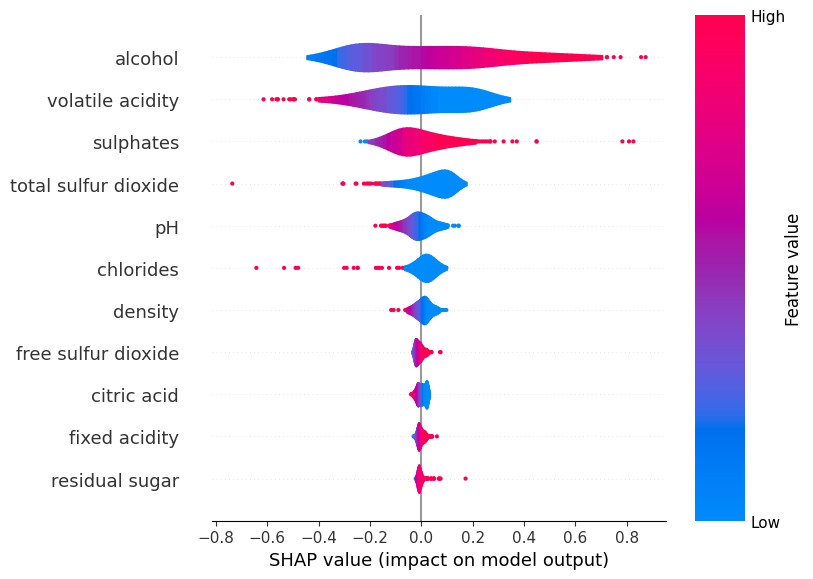

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type='violin', show=False)
plt.gcf().axes[-1].set_box_aspect(10)

The summary plot combines feature importance with feature effects. The x-axis stands for SHAP value, and the y-axis has all the features. The plot sorts features by the sum of SHAP value magnitudes over all samples, and shows the distribution of the impacts that each feature on the model output.  Red color means higher value of a feature. Blue means lower value of a feature. Positive SHAP value means positive effect on the outcome, negative SHAP value means negative effect on the outcome. We can get the general sense of features’ directionality impact based on the distribution of the red and blue areas.  

3. From the above diagram, what are the top three features that have the highest contribution to the model's prediction and how does each class, within these features, contributes to the model's output?

Answer: In the chart above, we can conclude the following insights:

Higher value of “alcohol” leads to higher quality of wine. Lower value of “alcohol” leads to lower quality of wine. Lower number of "volatile acidity" leads to higher quality of wine, and wise versa. Higher number of "sulphates" leads to medium-high quality of wine, and wise versa.

#TreeExplainer for Ensemble models

In this example, we will using the German Credit Risk dataset from UCI. This dataset is comprised of 1000 entries of people who took a credit from a bank. Each applicant is categorized as good or bad credit risks according to the set of features present in the dataset. We will start by loading the dataset, and printing the first few rows.

In [ ]:
url ='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0UKXEN/labs/german_credit_data.csv'
data  = pd.read_csv(url, index_col=0)

In [ ]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Now, we will segregate the numeric and categorical columns, and account for missing values by filling NANs with 'Unknown'.

We will use Light Gradient Boosting Machine (LGBM) algorithm as our model. It can directly use categorical variables, and hence, we will not go for One-Hot Encoding. We will use label encoding to handle categorical columns.

In [ ]:
num_features = ['Age', 'Credit amount', 'Duration']
cat_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Purpose']

In [ ]:
missing_features = ['Saving accounts', 'Checking account']
data[missing_features].isna().sum()/1000 * 100
data.fillna('Unknown', inplace=True)
le = LabelEncoder()
for feat in ['Sex', 'Housing', 'Saving accounts','Checking account', 'Purpose','Risk']:
    le.fit(data[feat])
    data[feat] = le.transform(data[feat])
classes = list(le.classes_)

Similar to what we did in the previous example, we will split the dataset into a feature set and the target, Risk.

In [ ]:
features = data.drop(columns=['Risk'])
labels = data['Risk']

1. Divide the data into training-test set with a 80:20 split ratio.

In [ ]:
## Write your solution here

x_train,x_test,y_train,y_test = train_test_split(features, labels, test_size = 0.2, random_state = 123)

We will now create datasets that are compatible for the Light GBM model.

In [ ]:
data_train = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_features)
data_test = lgb.Dataset(x_test, label=y_test, categorical_feature=cat_features)

Let's proceed by building a baseline tree ensemble ML model using the Light Gradient Boosting Machine (LGBM) algorithm. We can define a few model configuration parameters. Most of these are chosen arbitrarily and can be played around with.

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'seed': 123
}

2. Write some code to train the model using the parameters defined earlier, as well as the following:num_boost_round=100, verbose_eval=100, and data_test and data_train as the valid_sets

In [ ]:
import lightgbm as lgb
print(lgb.__version__)

4.0.0


In [ ]:
!pip install --upgrade lightgbm

  Using cached lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


In [ ]:
!pip install lightgbm==4.0.0

  Using cached lightgbm-4.0.0-py3-none-manylinux_2_28_x86_64.whl (3.0 MB)
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [ ]:
import lightgbm as lgb

# Initialize your Dataset with free_raw_data=False
data_train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
data_test = lgb.Dataset(x_test, label=y_test, reference=data_train)

# Train the model
model = lgb.train(
    params,
    data_train,
    num_boost_round=100,
    valid_sets=[data_test, data_train],
)

We can use this model to generate predictions on our test set. If the value of the prediction is above 0.5, we set it to 1 and 0 otherwise.

In [ ]:
y_pred = model.predict(x_test)
y_pred = [1 if y > 0.5 else 0 for y in y_pred]
print(f'Accuracy for the baseline model is: {accuracy_score(y_test, y_pred)}')

Accuracy for the baseline model is: 0.775


3. Now, we would like to focus on the model's explainability. Let's apply the TreeExplainers() and compute SHAP values for LGBM model.

In [ ]:
## Write your solution here

explainer = shap.TreeExplainer(model, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)


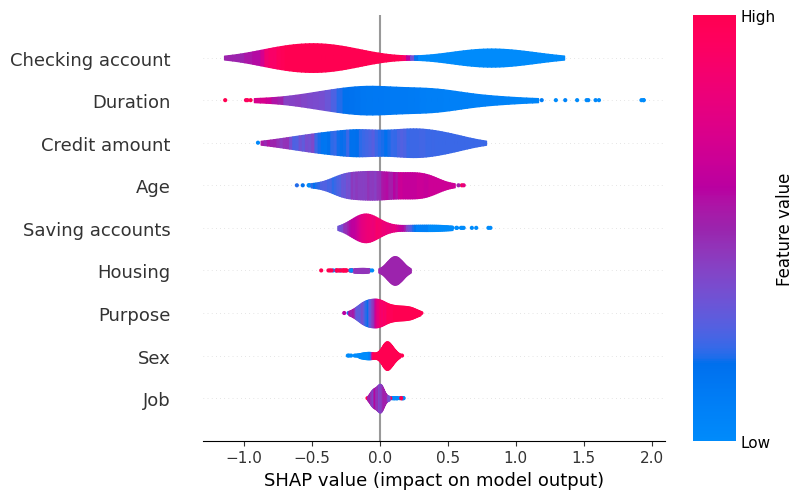

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type='violin', show=False)
plt.gcf().axes[-1].set_box_aspect(10)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


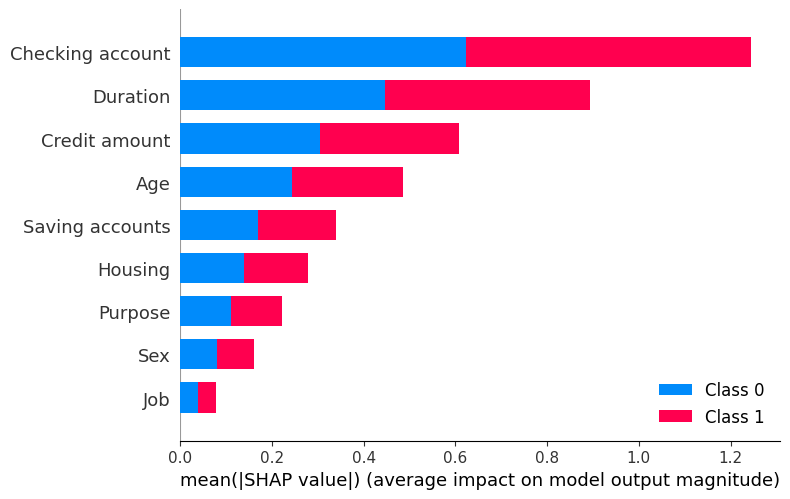

In [ ]:
shap.summary_plot(shap_values, x_test, plot_type='bar', show=False)

The plot shows the average impact of features on the model's predictions. As we see, the highest impact features from the dataset are: "Checking account", "Duration" and "Credit amount".

#GradientExplainer for CNN models on MNIST
In this example, we will demonstrate how a CNN trained on MNIST data can be explained using SHAP's DeepExplainer.

We will begin by loading the MNIST dataset directly from Keras.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Next, we perform a bit of pre-processing on our images like normalization, converting the type to float32, and reshaping the images to a 28x28 size.

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


Let us now define our model that we aim to explain. We will be using the Adam optimizer, sparse categorical cross-entropy as our loss function, and accuracy as our performance metric.

In [ ]:
input1 = Input(shape=(28,28,1))
input2 = Input(shape=(28,28,1))
input2c = Conv2D(32, kernel_size=(3, 3), activation='relu')(input2)
joint = tf.keras.layers.concatenate([Flatten()(input1), Flatten()(input2c)])
out = Dense(10, activation='softmax')(Dropout(0.2)(Dense(128, activation='relu')(joint)))
model = tf.keras.models.Model(inputs = [input1, input2], outputs=out)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit([x_train, x_train], y_train, epochs=1)

1875/1875 [==============================] - 190s 100ms/step - loss: 0.1679 - accuracy: 0.9493


Now, we will use the GradientExplainer to explain the model's output. Since we have two inputs we pass a list of inputs to the Explainer. Then, we explain the model's predictions on the first three samples of the test set.

In [ ]:
explainer = shap.GradientExplainer(model, [x_train, x_train])

shap_values = explainer.shap_values([x_test[:3], x_test[:3]])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


1. Plot the image_plot using SHAP values ([shap_values[i][0] for i in range(10)]) for the first three samples of the test set.

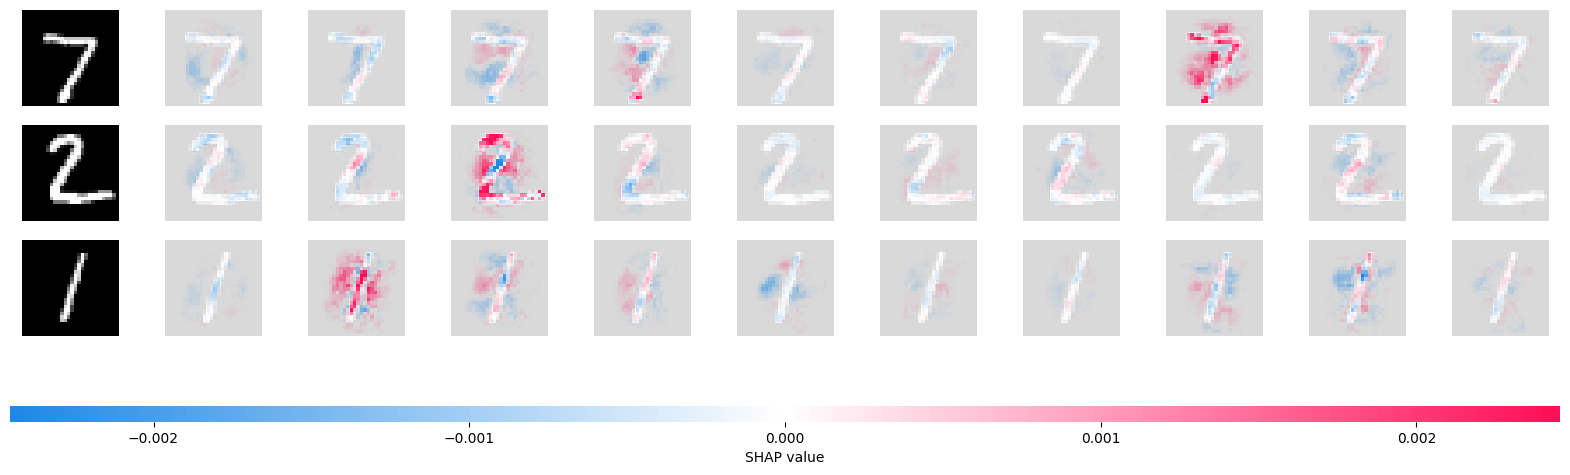

In [ ]:
## Write your solution here
shap.image_plot([shap_values[i][0] for i in range(10)], x_test[:3])

Image classification tasks can be explained by the scores on each pixel on a predicted image, which indicates how much it contributes to the probability positively or negatively. The rows indicate the test images and the columns are the classes from 0 to 9 going left to right. Red pixels increase the probability of a class being predicted, while blue pixels decrease the probability of a class being predicted. So in the diagram above, we see more red in class 7, class 2, and class 1, as the probability of those classes is increased, since they are correctly predicted classes.

#Sentiment Analysis

#SHAP Explainer for Transformer models
One of the SHAP Explainers for Transformer models is called Hugging Face Transformers. They are state-of-the-art pre-trained transformer models trained on huge amounts of data. We can utilize these pre-trained models on various applications by easily downloading them and fine-tuning them on custom datasets.

We will attempt to use the Hugging Face Transformer model for text sentiment analysis. Let's load the pipeline for sentiment analysis and input some random text.

In [5]:
!pip install -q datasets

In [6]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
from transformers import AutoTokenizer

In [10]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [12]:
emotions_encoded = emotions.map(tokenize, batched=True,
                                batch_size=None)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [13]:
from transformers import DataCollatorWithPadding

In [14]:
data_collator=DataCollatorWithPadding(tokenizer=tokenizer,
                                     return_tensors="tf")

In [15]:
!pip install -q evaluate

In [16]:
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-probability

In [17]:
import evaluate

In [18]:
accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions,
                            references = labels)

In [20]:
id2label={0:"sadness",1:"joy",2:"love",3:"anger",4:"fear",5:"suprise"}
label2id={"sadness":0,"joy":1,"love":2,"anger":3,"fear":4,"suprise":5}

In [21]:
from transformers import TFAutoModelForSequenceClassification

In [22]:
model=TFAutoModelForSequenceClassification.from_pretrained(
    model_ckpt, num_labels=6, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [23]:
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

text_data = "This book is pretty interesting but its too long"

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


We have two classes: POSITIVE and NEGATIVE output classes with their corresponding scores. A large NEGATIVE score means that NEGATIVE outputs have overall high contribution to the model.

In [24]:
model(text_data)[0]

[{'label': 'NEGATIVE', 'score': 0.997021496295929},
 {'label': 'POSITIVE', 'score': 0.0029785099904984236}]

We will define SHAP Explainer object and calculate SHAP values:

In [25]:
explainer = shap.Explainer(model)
shap_values = explainer([text_data])

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.61s/it]               


Next, we can call the force_plot method to visualize how features contribute to individual predictions.

Alternatively, we can use a bar plot to show how features contribute to individual predictions.

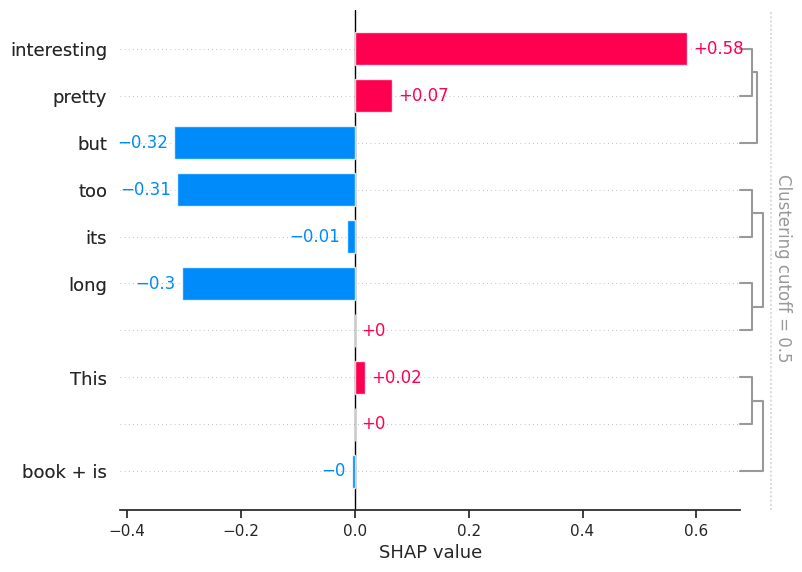

In [26]:
shap.plots.bar(shap_values[0,:,'POSITIVE'])

1. By analyzing the plots above, what features have a positive impact on the prediction and what features have a negative impact on the prediction?

Answer:
Features like "but", "too", "long" have a negative impact, while features like "pretty" and "interesting" have a positive impact on the prediction.

#2. Now, pick a sentence of your choice, and create SHAP force and bar plots, like shown above.

  0%|          | 0/182 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.96s/it]               


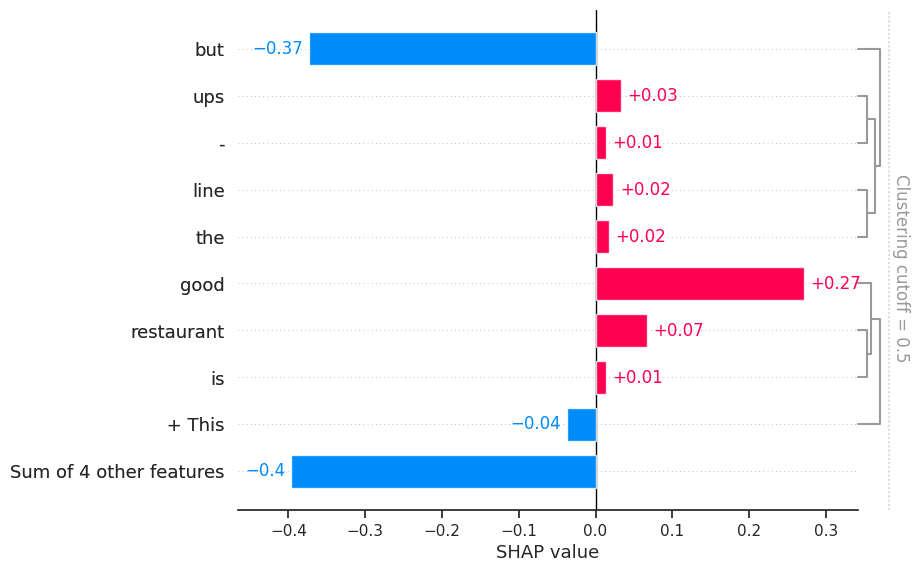

In [27]:
text_data2 = "This restaurant is good but the line-ups are too long"
model(text_data2)[0]
shap_values2 = explainer([text_data2])
shap.plots.text(shap_values2[0,:,'POSITIVE'])
shap.plots.bar(shap_values2[0,:,'POSITIVE'])

Test 3

In [28]:
model = transformers.pipeline('sentiment-analysis', return_all_scores=True)

text_data = "This is a stupid project."

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [29]:
model(text_data)[0]

[{'label': 'NEGATIVE', 'score': 0.9998024106025696},
 {'label': 'POSITIVE', 'score': 0.00019758530834224075}]

In [30]:
explainer = shap.Explainer(model)
shap_values = explainer([text_data])

  0%|          | 0/56 [00:00<?, ?it/s]

In [31]:
import shap
shap.initjs()

In [32]:
from IPython.display import display

In [33]:
shap.plots.text(shap_values[0,:,'POSITIVE'])

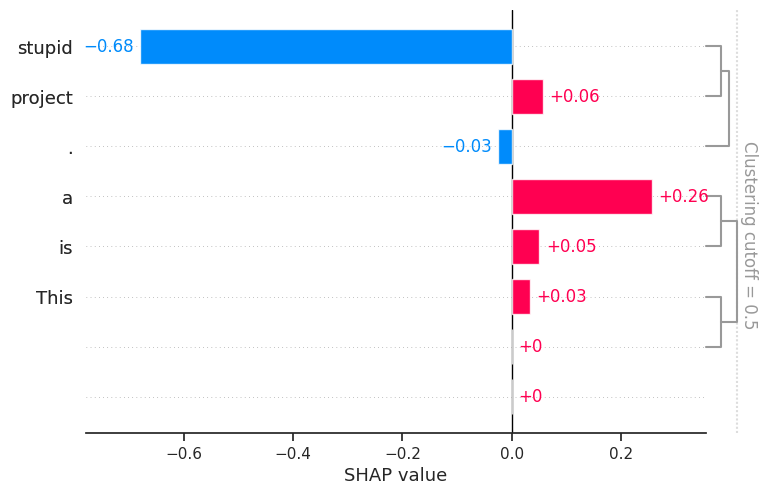

In [34]:
shap.plots.bar(shap_values[0,:,'POSITIVE'])

#Conclusion
Model Explainability techniques allow us to generate further insights about our data and to compare them with general understanding of the problem. This way we can trust that the model is intuitive and is making the right decisions.